In [433]:
import pandas as pd
import numpy as np
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.preprocessing import StandardScaler, PolynomialFeatures

warnings.filterwarnings("ignore")
np.random.seed(42)

In [434]:
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import rank2d

In [435]:
grid_search_enable = True
cv = 2
verbose = 3
number_of_jobs = -1
rand_state = 101

In [436]:
bdf = pd.read_csv("featured_bank_imputed_wo_duration_year.csv")

### Feature engineering

In [437]:
def festivals(month):
    # imputing festivals - apr: easter; jun:carnival; dec:christmas
    if month == 'apr' or month == 'jun' or month == 'dec':
        return 1
    else:
        return 0

In [438]:
bdf['f.festivals'] = bdf['month'].apply(festivals)

In [439]:
def bonus_months(month):
    # bonus paid twice in a year - may and nov
    if month == 'jun' or month == 'dec':
        return 1
    else:
        return 0

In [440]:
bdf['f.bonus_months']= bdf['month'].apply(bonus_months)

In [441]:
def commitment(housing, personal, marital):
    # if a person is married and has housing and personal loans, flag it as high commitment
    if housing == 'yes' and personal == 'yes' and marital == 'married':
        return 'high'
    if housing == 'no' and personal == 'no' and marital in ['single']:
        return 'low'
    else:
        return 'medium'

In [442]:
bdf['f.commitment'] = bdf.apply(lambda x: commitment(x.housing, x.loan, x.marital), axis=1)

In [443]:
def seasons(month):
    if month in ['mar','apr','may']:
        return 'spring'
    if month in ['jun','jul','aug']:
        return 'summer'
    if month in ['sep','oct','nov']:
        return 'autumn'
    if month in ['dec','jan','feb']:
        return 'winter'

In [444]:
bdf['f.seasons'] = bdf['month'].apply(lambda mon: seasons(mon))

In [445]:
def seasons_weightage(season):
    if season == 'autumn':
        return 21
    if season == 'spring':
        return 36
    if season == 'summer':
        return 40
    if season == "winter":
        return 2

In [446]:
bdf ['f.season_weight'] = bdf['f.seasons'].apply(lambda season: seasons_weightage(season))

In [447]:
def retired(age):
    if age >= 65:
        return 'retired'
    else:
        return 'not-retired'

In [448]:
bdf['f.retired_status'] = bdf['age'].apply(lambda age: retired(age))

In [449]:
def marital_weightage(marital):
    if marital == 'divorced':
        return 1
    if marital == 'single':
        return 35
    if marital == 'married':
        return 54

In [450]:
bdf['f.marital_weightage'] = bdf['marital'].apply(lambda status: marital_weightage(status))

In [451]:
def age_weightage(age):
    if age == '11_to_20':
        return 0.01
    if age == '21_to_30':
        return 0.23
    if age == '31_to_40':
        return 0.34
    if age == '41_to_50':
        return 0.18
    if age == '51_to_60':
        return 0.14
    if age == '61_to_70':
        return 0.04
    if age == '71_to_80':
        return 0.03
    if age == '81_to_90':
        return 0.01
    if age == '91_to_100':
        return 0.00
        

In [452]:
bdf['f.age_weightage'] = bdf['f.age'].apply(lambda age: age_weightage(age))

In [453]:
def job_salary(job):
    if job in ['blue-collar','housemaid']:
        return 700*12
    if job in ['admin.','technician']:
        return 1200*12
    if job in ['services']:
        return 1000*12
    if job in ['retired']:
        return 700*12
    if job in ['student', 'unemployed']:
        return 600*12
    if job in ['self-employed']:
        return 1200*12
    if job in ['entrepreneur']:
        return 1500*12
    if job in ['management']:
        return 2200*12

In [454]:
bdf['f.salary'] = bdf['job'].apply(lambda job: job_salary(job))

In [455]:
def income_tax(salary):
    if salary >=0 and salary <=7112:
        return 14.5
    if salary >=7113 and salary <=10732:
        return 23
    if salary >=10733 and salary <=20322:
        return 28.5
    if salary >=20323 and salary <=25075:
        return 35
    if salary >=25076 and salary <=36967:
        return 37
    if salary >=36968:
        return 45

In [456]:
bdf['f.income_tax'] = bdf['f.salary'].apply(lambda salary: income_tax(salary))

In [457]:
def previous_user(previous):
    if previous == 0:
        return 'new user'
    else:
        return 'existing user'

In [458]:
bdf['f.user_type'] = bdf['previous'].apply(lambda previous: previous_user(previous))

In [459]:
def previous_no_of_times(previous):
    # if a user is part of the previous campaign, bin them
    if previous == 0:
        return 'no previous'
    if previous >= 1 and previous <= 3:
        return '1_to_3'
    if previous > 3:
        return 'gt_3'
    

In [460]:
bdf['f.previous_campaigns'] = bdf['previous'].apply(lambda previous: previous_no_of_times(previous))

In [461]:
def current_campaign_calls(calls):
    # how many times a user is called
    if calls == 1:
        return 'once'
    if calls >= 2 and calls <= 3:
        return 'twice to thrice '
    if calls > 3 and calls <= 6:
        return 'four to six times'
    if calls >= 7 and calls <= 10:
        return 'seven to ten times'
    if calls > 10:
        return 'more than ten times'
    

In [462]:
bdf['f.current_campaign_calls'] = bdf['campaign'].apply(lambda calls: current_campaign_calls(calls))

In [463]:
def first_time_user_calls(previous, campaigns):
    # first time user - not a part of previous campaign
    # first time the user is speaking - what's the conversion rate
    if previous == 0:
        if campaigns == 1:
            return 'first time called'
        if campaigns >= 2 and campaigns <= 3:
            return 'called atleast twice'
        if campaigns > 3:
            return 'called atleast thrice'
        else:
            return 'more than thrice'
    else:
        return 'returning user'

In [464]:
bdf['f.first_time_user_calls'] = bdf.apply(lambda x: first_time_user_calls(x.previous, x.campaign), axis=1)

In [465]:
def savings_intention(job):
    if job in ['admin.','blue-collar','technician']:
        return 75
    elif job in ['retired','management','services']:
        return 50
    else:
        return 25

In [466]:
bdf['f.savings_intent_factor'] = bdf['job'].apply(lambda job: savings_intention(job))

In [467]:
def age_range_weightage(age):
    if age <= 24:
        return 0.15
    if age >=25 and age <= 69:
        return 0.61
    if age >= 70 and age <= 80:
        return 0.13
    if age > 80:
        return 0.04

In [468]:
bdf['f.age_range_weightage'] = bdf['age'].apply(lambda age: age_range_weightage(age))

In [469]:
def avg_income_distribution(salary, marital):
    if marital == 'married':
        return round((salary/3),2)
    if marital == 'single':
        return salary
    if marital == 'divorced':
        return round((salary/2),2)
    

In [470]:
bdf['f.avg_income_dist'] = bdf.apply(lambda x: avg_income_distribution(x['f.salary'], x['marital']), axis=1)

In [471]:
def p_days_bin(pdays):
    if pdays >=0 and pdays <=6:
        return 'within a week'
    if pdays >=7 and pdays <=13:
        return 'within two weeks'
    if pdays >= 14 and pdays <=20:
        return 'within three weeks'
    if pdays > 20:
        return 'more than three weeks'

In [472]:
bdf['f.pdays'] = bdf['pdays'].apply(lambda days: p_days_bin(days))

In [473]:
def year_weightage(year):
    if year == "Y2008":
        return 5
    if year == "Y2009":
        return 14
    if year == "Y2010":
        return 52

In [474]:
bdf['f.year_weightage'] = bdf['f.year'].apply(lambda year: year_weightage(year))

In [475]:
def recession_strength(year):
    if year == "Y2008":
        return 75
    if year == "Y2009":
        return 50
    if year == "Y2010":
        return 25

In [476]:
bdf['f.recession_strength'] = bdf['f.year'].apply(lambda year: recession_strength(year))

In [477]:
def unemployment_rate(year):
    if year == "Y2008":
        return 7.55
    if year == "Y2009":
        return 9.43
    if year == "Y2010":
        return 10.77

In [478]:
bdf['f.unemployment_rate'] = bdf['f.year'].apply(lambda year: unemployment_rate(year))

In [479]:
def pat_weight(pattern):
    if pattern == "no":
        return 0
    if pattern in ['PE12A','PE12D','PE12G','PE4A']:
        return 2
    if pattern in ['PE12B','PE12F','PE1L','PEIJ']:
        return 3
    if pattern in ['PE1A','PE1F','PE1H']:
        return 5
    if pattern in ['PE1G','PE1K']:
        return 6
    if pattern in ['PE1B','PE1C']:
        return 8
    if pattern in ['PE1D']:
        return 10
    

In [480]:
bdf['f.pattern_weight'] = bdf['f.pattern'].apply(lambda pattern: pat_weight(pattern))

### Feature Analysis

In [481]:
dropped_columns= ['s.no', 'age', 'emp.var.rate','cons.conf.idx','nr.employed','default','pdays', 'f.year', 
                  'f.year_weightage','f.unemployment_rate','f.pattern_weight' ]
categorical_columns=['job','education','marital','housing','loan','contact','month','day_of_week',
                     'poutcome','f.euribor','f.age', 'f.commitment','f.pattern',
                    'f.seasons','f.retired_status', 'f.user_type', 
                     'f.previous_campaigns','f.current_campaign_calls','f.first_time_user_calls', 
                     'f.pdays',
                    ]

In [482]:
# drop the columns
bdf.drop(dropped_columns, axis=1, inplace=True)

In [483]:
#convert columns of object type to categorical columns
bdf_cat = bdf[categorical_columns].astype('category')

In [484]:
bdf[categorical_columns] = bdf[categorical_columns].astype('category')

In [485]:
# drop bdf categorical columns from the dataframe
bdf_noncat = bdf.drop(categorical_columns,axis=1)

In [486]:
bdf_noncat.columns

Index(['campaign', 'previous', 'cons.price.idx', 'euribor3m', 'y',
       'f.festivals', 'f.bonus_months', 'f.season_weight',
       'f.marital_weightage', 'f.age_weightage', 'f.salary', 'f.income_tax',
       'f.savings_intent_factor', 'f.age_range_weightage', 'f.avg_income_dist',
       'f.year_weightage', 'f.recession_strength', 'f.unemployment_rate'],
      dtype='object')

In [487]:
# use one hot encoding for categorical columns
bdf_cat_one_hot = pd.get_dummies(bdf_cat)

In [488]:
bdf_cat_one_hot.shape

(41188, 101)

In [489]:
#concat categorical df with non categorical df
bdf_master = pd.concat([bdf_noncat, bdf_cat_one_hot], axis=1)

In [490]:
# store only the target variable column
y = bdf_master.pop('y')

In [491]:
# remove the target variable column from the master dataset
X = bdf_master

In [492]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=101)

In [493]:
y_train.value_counts()

no     27416
yes     3475
Name: y, dtype: int64

In [494]:
y_test.value_counts()

no     9132
yes    1165
Name: y, dtype: int64

In [495]:
# the propotion of yes and no looks the same

### Visualizing classification report

In [496]:
def show_classification_rpt(model):
    visualizer = ClassificationReport(model, classes=['no','yes'], cmap="YlGn", size=(600,300))
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()

# Model Building

In [497]:
# function that fits and predicts
def fit_predict(algo,X_train, X_test, y_train, y_test):
    algo.fit(X_train, y_train)
    y_pred = algo.predict(X_test)
    return y_pred

## Logistic Regression

In [498]:
logit = LogisticRegression()

In [499]:
print("Accuracy with Logistic Regression", end=': ')
y_pred_logit = fit_predict(logit, X_train, X_test, y_train, y_test)
logit_accuracy = accuracy_score(y_test, y_pred_logit)
print(logit_accuracy)

Accuracy with Logistic Regression: 0.8882198698650092


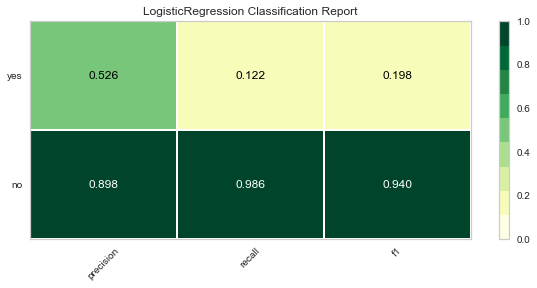

In [500]:
show_classification_rpt(logit)

In [501]:
print(classification_report(y_test, y_pred_logit))

              precision    recall  f1-score   support

          no       0.90      0.99      0.94      9132
         yes       0.53      0.12      0.20      1165

    accuracy                           0.89     10297
   macro avg       0.71      0.55      0.57     10297
weighted avg       0.86      0.89      0.86     10297



In [502]:
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred_logit))

Confusion Matrix:
[[9004  128]
 [1023  142]]


## Decision Tree

In [503]:
tree = DecisionTreeClassifier(random_state=rand_state)

In [504]:
print("Accuracy with Decision Tree", end=': ')
y_pred_tree = fit_predict(tree, X_train, X_test, y_train, y_test)
tree_accuracy = accuracy_score(y_test, y_pred_tree)
print(tree_accuracy)

Accuracy with Decision Tree: 0.851898611245994


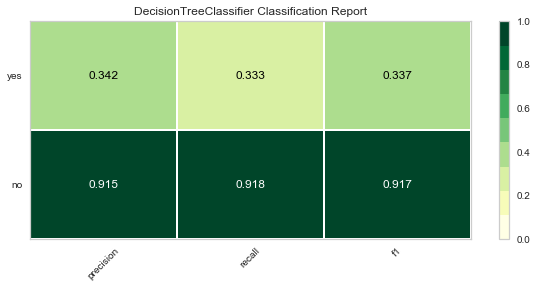

In [505]:
show_classification_rpt(tree)

In [506]:
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred_tree))

Confusion Matrix:
[[8384  748]
 [ 777  388]]


### Hyper Parameter Tuning

In [507]:
def fit_predict_dt(train, test, y_train, y_test, scaler, max_depth,
               criterion = 'entropy', max_features=1, min_samples_split=4):
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)
    dt = DecisionTreeClassifier(criterion = criterion, max_depth=max_depth,
                               random_state= 101, max_features=max_features,
                               min_samples_split=min_samples_split)
    dt.fit(train_scaled, y_train)
    y_pred = dt.predict(test_scaled)
    return y_pred

### Max depth parameter tuning

In [508]:
list_max_depth = []

In [509]:
for i in range(1,30):
    print("Accuracy score using max_depth = ", i, end = ':')
    y_pred_tree_hpt = fit_predict_dt(X_train, X_test, y_train, y_test, StandardScaler(), i)
    dt_max_depth = accuracy_score(y_test, y_pred_tree_hpt)
    print(dt_max_depth)
    list_max_depth.append(dt_max_depth)
    
max_depth_tuned = list_max_depth.index(max(list_max_depth))+1
print(max_depth_tuned)

Accuracy score using max_depth =  1:0.8868602505584151
Accuracy score using max_depth =  2:0.8870544818879286
Accuracy score using max_depth =  3:0.8870544818879286
Accuracy score using max_depth =  4:0.8870544818879286
Accuracy score using max_depth =  5:0.8871515975526852
Accuracy score using max_depth =  6:0.8872487132174419
Accuracy score using max_depth =  7:0.8872487132174419
Accuracy score using max_depth =  8:0.8859862095756046
Accuracy score using max_depth =  9:0.8880256385354958
Accuracy score using max_depth =  10:0.8886083325240361
Accuracy score using max_depth =  11:0.8888996795183063
Accuracy score using max_depth =  12:0.8887054481887928
Accuracy score using max_depth =  13:0.8865689035641449
Accuracy score using max_depth =  14:0.8894823735068467
Accuracy score using max_depth =  15:0.8871515975526852
Accuracy score using max_depth =  16:0.8876371758764688
Accuracy score using max_depth =  17:0.8874429445469554
Accuracy score using max_depth =  18:0.8847237059337671
A

### Max features tuning

In [510]:
dict_max_features = {}

In [511]:
for i in np.arange(0.1,1.0,0.1):
    print('Accuracy score using max features =', i, end = ":")
    y_pred_max_features = fit_predict_dt(X_train, X_test, y_train, y_test, StandardScaler(), max_depth=max_depth_tuned, max_features=i)
    dt_max_features = accuracy_score(y_test, y_pred_max_features)
    print(dt_max_features)
    dict_max_features[i]=dt_max_features

max_feature_tuned = max(dict_max_features, key=dict_max_features.get)
print(max_feature_tuned)

Accuracy score using max features = 0.1:0.8916189181314946
Accuracy score using max features = 0.2:0.8888996795183063
Accuracy score using max features = 0.30000000000000004:0.8923958434495484
Accuracy score using max features = 0.4:0.8915218024667378
Accuracy score using max features = 0.5:0.8905506458191706
Accuracy score using max features = 0.6:0.8894823735068467
Accuracy score using max features = 0.7000000000000001:0.8899679518306303
Accuracy score using max features = 0.8:0.8894823735068467
Accuracy score using max features = 0.9:0.8904535301544139
0.30000000000000004


### Min samples split tuning

In [512]:
dict_min_samples_split = {}

In [513]:
for i in range(2,10):
    print('Accuracy score using min samples split=', i, end=":")
    y_pred_min_split = fit_predict_dt(X_train, X_test, y_train, y_test, StandardScaler(), max_depth=max_depth_tuned, max_features=max_feature_tuned, min_samples_split=i)
    dt_min_sample_split = accuracy_score(y_test, y_pred_min_split)
    print(dt_min_sample_split)
    dict_min_samples_split[i] = dt_min_sample_split
    
min_sample_split_tuned = max(dict_min_samples_split, key=dict_min_samples_split.get)
print(min_sample_split_tuned)

Accuracy score using min samples split= 2:0.8895794891716033
Accuracy score using min samples split= 3:0.8892881421773332
Accuracy score using min samples split= 4:0.8923958434495484
Accuracy score using min samples split= 5:0.8902592988249004
Accuracy score using min samples split= 6:0.892201612120035
Accuracy score using min samples split= 7:0.8917160337962513
Accuracy score using min samples split= 8:0.892201612120035
Accuracy score using min samples split= 9:0.8895794891716033
4


### Criterion tuning

In [514]:
dict_index_tuned = {}

In [515]:
for i in ['gini','entropy']:
    print("Accuracy score using criterion: ", i, end = ':')
    y_pred_index_score = fit_predict_dt(X_train, X_test, y_train, y_test, StandardScaler(), max_depth=max_depth_tuned, max_features = max_feature_tuned, min_samples_split=min_sample_split_tuned, criterion= i)
    dt_index_score = accuracy_score(y_test, y_pred_index_score)
    print(dt_index_score)
    dict_index_tuned[i] = dt_index_score

dt_index_tuned = max(dict_index_tuned, key=dict_index_tuned.get)
print(dt_index_tuned)

Accuracy score using criterion:  gini:0.8869573662231718
Accuracy score using criterion:  entropy:0.8923958434495484
entropy


### Rerunning decision tree with best parameters

In [516]:
tree_best_pred  =  fit_predict_dt(X_train, X_test, y_train, y_test, StandardScaler(), max_depth=max_depth_tuned, max_features = max_feature_tuned, min_samples_split=min_sample_split_tuned, criterion= dt_index_tuned)
dt_best_param_score = accuracy_score(y_test, tree_best_pred)
print("Accuracy score for decision tree using best param: ", end = ':')
print(dt_best_param_score)

Accuracy score for decision tree using best param: :0.8923958434495484


In [517]:
tree1 = DecisionTreeClassifier(criterion = dt_index_tuned, max_depth=max_depth_tuned,
                               random_state= rand_state, max_features=max_feature_tuned,
                               min_samples_split=min_sample_split_tuned)

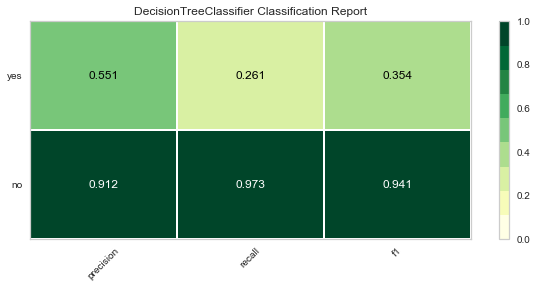

In [518]:
show_classification_rpt(tree1)

In [519]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, tree_best_pred))

Confusion Matrix:
[[8885  247]
 [ 861  304]]


## Random Forest

In [520]:
forest = RandomForestClassifier(criterion='entropy', oob_score=True)

In [521]:
print("Accuracy with Random Forest", end=': ')
rf_pred = fit_predict(forest, X_train, X_test, y_train, y_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
print(rf_accuracy)

Accuracy with Random Forest: 0.8925900747790618


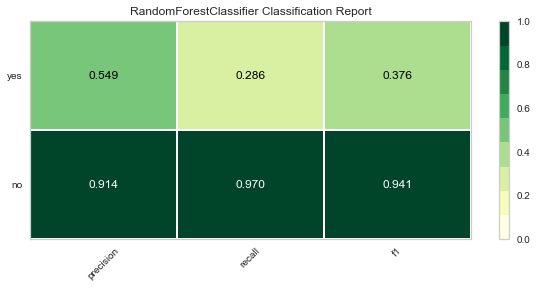

In [522]:
show_classification_rpt(forest)

In [523]:
print("Confusion Matrix:")
print(confusion_matrix(y_test,rf_pred))

Confusion Matrix:
[[8858  274]
 [ 832  333]]


## Accuracy Summary Without Boosting

In [524]:
print("Accuracy with Logistic Regression", end=': ')
print(logit_accuracy)
print("Accuracy with Decision Tree", end=': ')
print(tree_accuracy)
print("Accuracy of Decision Tree after Hyper Parameter Tuning: ", end = ':')
print(dt_best_param_score)
print("Accuracy with Random Forest", end=': ')
print(rf_accuracy)

Accuracy with Logistic Regression: 0.8882198698650092
Accuracy with Decision Tree: 0.851898611245994
Accuracy of Decision Tree after Hyper Parameter Tuning: :0.8923958434495484
Accuracy with Random Forest: 0.8925900747790618


## LGBM

In [525]:
from lightgbm import LGBMClassifier

In [526]:
LGBM = LGBMClassifier(n_jobs=number_of_jobs, num_leaves=31)
LGBM.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [527]:
LGBM_predict = LGBM.predict(X_test)

In [528]:
print("Accuracy with LGBM", end=': ')
lgbm_accuracy = accuracy_score(y_test,LGBM_predict)
print(lgbm_accuracy)

Accuracy with LGBM: 0.9024958725842478


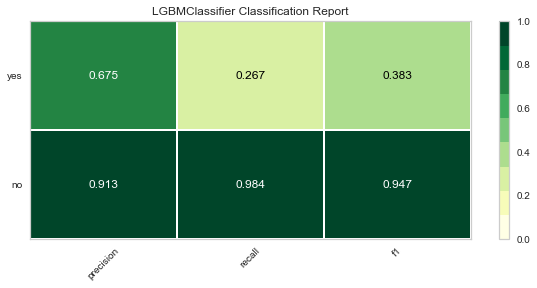

In [529]:
show_classification_rpt(LGBM)

In [530]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, LGBM_predict))

Confusion Matrix:
[[8982  150]
 [ 854  311]]


### LGBM With Grid Search

In [531]:
lgbm_params = {
    'num_leaves': [31,35,41,45],
    'learning_rate':[0.03,0.05,0.07,0.09],
    'n_estimators': [50,75,100,150]
}

In [532]:
if grid_search_enable == True:
    lgbm_gs = GridSearchCV(LGBM, lgbm_params, cv=cv, n_jobs=number_of_jobs)
    lgbm_gs.fit(X_train, y_train)

In [533]:
if grid_search_enable == True:
    lgbm_best_estimator = lgbm_gs.best_params_['n_estimators']
    lgbm_best_learning_rate = lgbm_gs.best_params_['learning_rate']
    lgbm_best_num_leaves = lgbm_gs.best_params_['num_leaves']
    # lgbm_best_max_depth = lgbm_gs.best_params_['max_depth']
    print(lgbm_gs.best_params_)

{'learning_rate': 0.07, 'n_estimators': 50, 'num_leaves': 31}


### LGBM With Best Parameters

In [534]:
if grid_search_enable == True:
    LGBM_best = LGBMClassifier(n_jobs=number_of_jobs, num_leaves=lgbm_best_num_leaves, 
                               learning_rate=lgbm_best_learning_rate, n_estimators=lgbm_best_estimator,
                              )
    LGBM_best.fit(X_train, y_train)

In [535]:
if grid_search_enable == True:
    LGBM_best_predict = LGBM_best.predict(X_test)
    LGBM_best_accuracy = accuracy_score(y_test,LGBM_best_predict)

In [536]:
if grid_search_enable == True:
    print("Accuracy with LGBM with Hyper Parameter Tuning", end=': ')
    print(LGBM_best_accuracy)

Accuracy with LGBM with Hyper Parameter Tuning: 0.9004564436243566


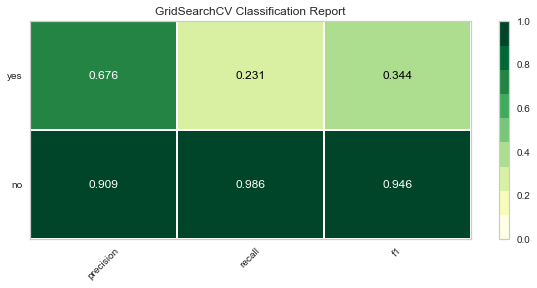

In [537]:
if grid_search_enable == True:
    show_classification_rpt(lgbm_gs)

In [538]:
if grid_search_enable == True:
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, LGBM_best_predict))

Confusion Matrix:
[[9003  129]
 [ 896  269]]


## Accuracy Summary With LGBM

In [539]:
print("Accuracy with Logistic Regression", end=': ')
print(logit_accuracy)

print("Accuracy with Decision Tree", end=': ')
print(tree_accuracy)
print("Accuracy with Decision Tree after Hyper Parameter Tuning: ", end = ':')
print(dt_best_param_score)

print("Accuracy with Random Forest", end=': ')
print(rf_accuracy)

print("Accuracy with LGBM", end=': ')
print(lgbm_accuracy)
if grid_search_enable == True:
    print("Accuracy with LGBM after Hyper Parameter Tuning", end=': ')
    print(LGBM_best_accuracy)    
    
    

Accuracy with Logistic Regression: 0.8882198698650092
Accuracy with Decision Tree: 0.851898611245994
Accuracy with Decision Tree after Hyper Parameter Tuning: :0.8923958434495484
Accuracy with Random Forest: 0.8925900747790618
Accuracy with LGBM: 0.9024958725842478
Accuracy with LGBM after Hyper Parameter Tuning: 0.9004564436243566
